In [1]:
import os
import sys
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import pandas as pd
from typing import List, Tuple

current_dir = os.path.dirname(os.getcwd())
sys.path.append(current_dir)

In [2]:
from extract_kilter_holds import ExtractKilterHolds
from node_feature_extractor import NodeFeatureExtractor
from climb_data_processing import ClimbDataProcessor

In [3]:
raw_data_dir = os.path.join(os.path.dirname(os.getcwd()), 'raw')

climb_processor = ClimbDataProcessor(raw_data_dir=raw_data_dir)

climb_processor.load_and_merge_data()
climb_processor.filter_gecko_board()

Loading and merging raw data...
Initial merged DataFrame shape: (293113, 25)
Filtering data for Gecko Board...
Filtered Gecko Board DataFrame shape: (2586, 11)


In [4]:
climb_processor.prepare_similarity_dataframe()

Preparing DataFrame for similarity analysis...
Similarity DataFrame prepared with shape: (847, 4)


In [5]:
climb_processor.calculate_similarity_matrix()

Starting similarity matrix calculation for 847 rows...
Processing row 0 of 847...
Processing row 100 of 847...
Processing row 200 of 847...
Processing row 300 of 847...
Processing row 400 of 847...
Processing row 500 of 847...
Processing row 600 of 847...
Processing row 700 of 847...
Processing row 800 of 847...
Similarity matrix calculation complete.


In [6]:
climb_processor.find_high_similarity_pairs(threshold=0.5)
climb_processor.deduplicate_by_quality_score()
climb_processor.drop_too_many_holds()

Finding high similarity pairs with threshold >= 0.50...
Found 206 pairs above the threshold.

--- Deduplication by Quality Score ---
Initial number of climbs: 2586
Number of climbs removed: 311
Final number of climbs: 2275
Starting 'drop_too_many_holds' on DataFrame of shape: (2275, 11)
Dropped 0 rows.
Final DataFrame shape: (2275, 11)


In [7]:
holds = ExtractKilterHolds(raw_data_dir)
processed_folder_path = os.path.join(os.path.dirname(os.getcwd()), 'processed', 'climbs')

Climb hold colors reset to default.
Climb hold type reset to default.
Data loaded and preprocessed successfully.


Climb hold colors reset to default.
Climb hold type reset to default.
Custom colors and types applied.
Loaded data from climbing route dataframe
Filtered data for Gecko board.
Normalized 'x' and 'y' coordinates.
One-hot encoded categorical columns: ['default_hold_color', 'climb_hold_type']
Populated node features dictionary.
Created node feature dataframe and matrix.


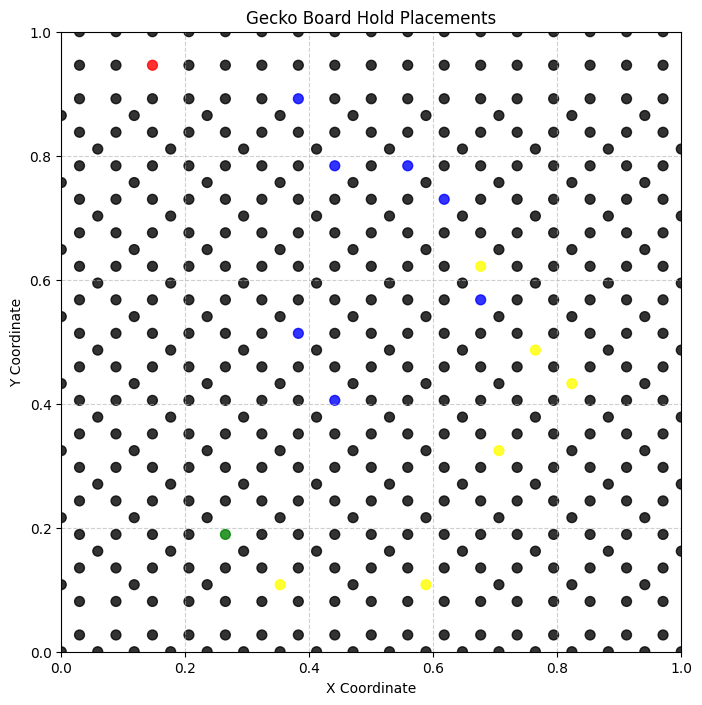

dumpling sauce (spicy)


In [8]:
i = 1
one_climb_data = climb_processor.df_gecko_climb_data.iloc[i]

holds.apply_climb(one_climb_data['frames'])
one_climb_data_frames = holds.gecko_board_df
extractor = NodeFeatureExtractor(holds.gecko_board_df)
extractor.plot_board()
print(one_climb_data['name'])
#csv_path = os.path.join(processed_folder_path, one_climb_data['uuid'] + '.csv')
#holds.save_current_board_to_csv(csv_path)
#print(one_climb_data['name'])

#csv_path = os.path.join(processed_folder_path, one_climb_data['uuid'] + '.csv')
#extractor = NodeFeatureExtractor(kilter_holds_csv_path=csv_path)
#extractor.plot_board()

In [10]:
hold_frequency = holds.calculate_hold_frequency_gecko_climbs(gecko_climbs_df=climb_processor.df_gecko_climb_data)


--- Pivoted new counts DataFrame ---
count_type    count_finish  count_foot  count_hand  count_start
placement_id                                                   
1077                   0.0         1.0         0.0          0.0
1155                   0.0         0.0         0.0          1.0
1225                   0.0         0.0         1.0          0.0
1255                   0.0         0.0         1.0          0.0
1324                   0.0         0.0         1.0          0.0
1337                   0.0         0.0         1.0          0.0
1369                   0.0         0.0         1.0          0.0
1382                   1.0         0.0         0.0          0.0
1447                   0.0         1.0         0.0          0.0
1471                   0.0         1.0         0.0          0.0
1480                   0.0         1.0         0.0          0.0
1518                   0.0         1.0         0.0          0.0
1533                   0.0         1.0         0.0          0.0
15

In [11]:
print(hold_frequency['count_foot'].max())

1


In [11]:
#Hold Frequency

holds_frequency = pd.DataFrame(holds.gecko_board_df['placement_id'])
holds_frequency["count_hand"] = 0
holds_frequency["count_start"] = 0
holds_frequency["count_finish"] = 0
holds_frequency["count_foot"] = 0

holds_frequency = holds_frequency.set_index('placement_id')

aggregated_counts = defaultdict(int)
pattern = r'p(\d{4})(r\d{2})'

for i in range(holds.gecko_board_df.shape[0]): # Using range(10) as specified in your code
    # Get the 'frames' string for the current climb
    frames_string = climb_processor.df_gecko_climb_data.iloc[i]['frames']
    
    # Extract all hold (ID, type) pairs from this frames string
    holds_used_in_climb = re.findall(pattern, frames_string)
    
    # Inner loop: iterate through holds in the current climb
    for hold_str, hold_type in holds_used_in_climb:
        hold_int = int(hold_str) # Convert hold ID to integer

        # Increment the corresponding counter in the defaultdict
        if hold_type == 'r12' or hold_type == 'r20' or hold_type == 'r24' or hold_type == 'r28':
            aggregated_counts[(hold_int, "count_start")] += 1
        elif hold_type == 'r13' or hold_type == 'r21' or hold_type == 'r25' or hold_type == 'r29':
            aggregated_counts[(hold_int, "count_hand")] += 1
        elif hold_type == 'r14' or hold_type == 'r22' or hold_type == 'r26' or hold_type == 'r30':
            aggregated_counts[(hold_int, "count_finish")] += 1
        elif hold_type == 'r15' or hold_type == 'r23' or hold_type == 'r27' or hold_type == 'r32':
            aggregated_counts[(hold_int, "count_foot")] += 1
        else:
            print(f"Warning: Unhandled hold_type '{hold_type}' for hold '{hold_str}'.")



In [12]:
if aggregated_counts: # Only proceed if counts were collected
    records = []
    for (placement_id, count_type), count in aggregated_counts.items():
        records.append({'placement_id': placement_id, 'count_type': count_type, 'count': count})

    df_temp_counts = pd.DataFrame(records)

    # Pivot the temporary DataFrame to match the structure of holds_frequency
    df_new_counts_pivoted = df_temp_counts.pivot_table(
        index='placement_id',
        columns='count_type',
        values='count',
        fill_value=0 # Fill missing count types for a given placement_id with 0
    )

    print("\n--- Pivoted new counts DataFrame ---")
    print(df_new_counts_pivoted)
    print("-" * 40)

    # Step 3: Update holds_frequency with the new counts
    # The .update() method efficiently updates existing rows/columns based on index alignment.
    holds_frequency.update(df_new_counts_pivoted)
else:
    print("No holds found in the specified climbs, holds_frequency remains unchanged.")


--- Pivoted new counts DataFrame ---
count_type    count_finish  count_foot  count_hand  count_start
placement_id                                                   
1073                   0.0        11.0         1.0          0.0
1074                   0.0         2.0         0.0          0.0
1075                   0.0         1.0         0.0          0.0
1076                   0.0         6.0         0.0          0.0
1077                   0.0        15.0         0.0          0.0
...                    ...         ...         ...          ...
1579                   0.0         3.0         0.0          0.0
1580                   0.0         4.0         0.0          0.0
1583                   0.0         3.0         0.0          0.0
1584                   0.0         2.0         0.0          0.0
1585                   0.0         0.0         1.0          0.0

[425 rows x 4 columns]
----------------------------------------


Climb hold colors reset to default.
Climb hold type reset to default.
Custom colors and types applied.


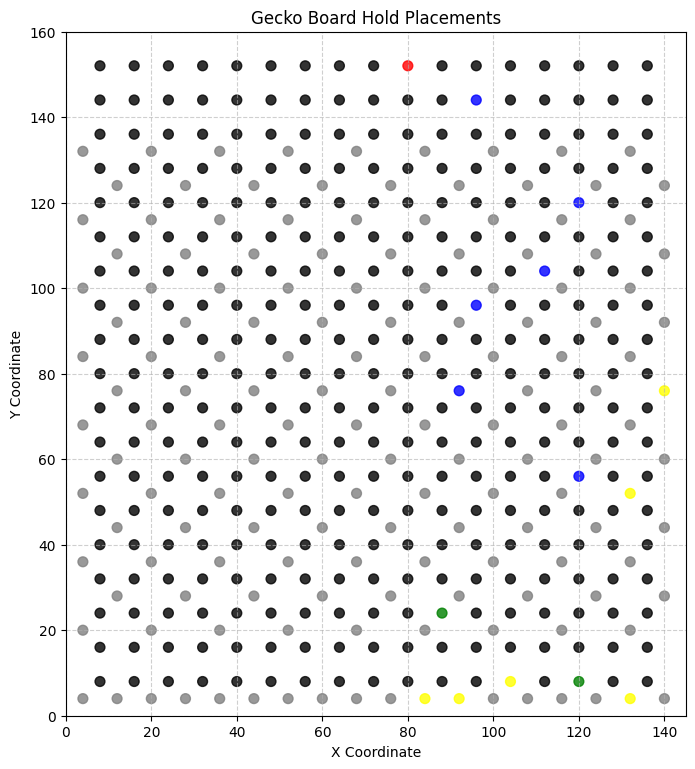

In [13]:
holds.apply_climb('p1075r12p1077r15p1117r20p1189r13p1271r13p1290r13p1325r13p1373r13p1388r14p1448r15p1453r15p1454r15p1509r15p1533r21p1536r15')
holds.plot_gecko_board()